In [1]:
#importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard, EarlyStopping
import tensorflow as tf
import datetime, IPython
import numpy as np
import os


In [2]:
#checking whether gpu is used or not
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def stop_cuda():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

In [5]:
#getting current directory path
path = os.getcwd()

In [6]:
#train_dir = '/home/jidesh/ML/CNN/Facial-expression/data/train'
#defining necessary details
train_dir = path+'/dataset/FacialExpression-Dataset/Train'
val_dir = path+'/dataset/FacialExpression-Dataset/Test'

checkpoint_losspath = path+'/Checkpoints/checkpoints_loss/Model-epoch_{epoch:02d}--val_loss_{val_loss:.2f}'
checkpoint_accpath = path+'/Checkpoints/checkpoints_acc/Model-epoch_{epoch:02d}--val_categorical_accuracy_{val_categorical_accuracy:.2f}'


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64
img_width = 48
img_height = 48

print("Train : ",train_dir)
print("Val : ",val_dir)

Train :  d:\project\project/dataset/FacialExpression-Dataset/Train
Val :  d:\project\project/dataset/FacialExpression-Dataset/Test


In [7]:
#preprocessing data to feed them into the algorithm
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')


Found 76577 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
#viewing dataset details
print("Train set size : {} class : {} no.of : {}".format(train_generator.samples,train_generator.class_indices,train_generator.num_classes))
train_sample_size = train_generator.samples
validation_sample_size = validation_generator.samples
print("validate set size : {} class : {} no.of : {}".format(validation_generator.samples,validation_generator.class_indices,validation_generator.num_classes))

Train set size : 76577 class : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6} no.of : 7
validate set size : 7178 class : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6} no.of : 7


In [22]:
#defining the model
emotion_model = Sequential()
 
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(img_height,img_width,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))
 
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))


emotion_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))

emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))
 
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(train_generator.num_classes, activation='softmax'))
################################################################################
emotion_model.load_weights(path+'/Models/sgd_weights/emotion-reg-weight-0.8758511543273926.h5')

In [25]:
print(emotion_model.load_weights )

<bound method Model.load_weights of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001D643C2E940>>


In [26]:
emotion_dict = train_generator.class_indices
print(emotion_dict)
#swapping key and values in dictionary
emotion_dict={value:key for key, value in emotion_dict.items()}
print(emotion_dict)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [17]:
#defining checkpoint to store model and its weights
checkpoint_loss = ModelCheckpoint(
    filepath=checkpoint_losspath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose =1
)
checkpoint_acc = ModelCheckpoint(
    filepath=checkpoint_accpath,
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose =1
)
#defining early stopping in order to avoid overfit and underfit
earlystop = EarlyStopping(monitor='val_loss', patience=5,mode='min')
#Tensorboard
time1 = (datetime.datetime.now() ).strftime('%c')
time1 = time1.replace(':','_')
#time1 = time1.replace(' ','_')
tensorboard = TensorBoard(path+'/Tensorboard/'+time1)
callback = [checkpoint_loss,checkpoint_acc,tensorboard,earlystop]

---------------------------------------------------------------------------------------------------------------------------------------------

**SGD Optimiser**

In [27]:
#defines the loss function, the optimizer and the metrics in order to compile the model
emotion_model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.01),metrics=['categorical_accuracy'])
emotion_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 12, 12, 512)      

In [13]:
#fit method estimates the best representative function for the the data points (could be a line, polynomial or discrete borders around). With that representation, we can ca
# lculate new data points.
#%%time
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=train_sample_size // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=validation_sample_size // batch_size,
        callbacks=callback)

Epoch 1/100
   5/1196 [..............................] - ETA: 23:06 - loss: 1.9497 - categorical_accuracy: 0.1469

KeyboardInterrupt: 

In [19]:
#defining path to  save model and its weights
path1 = path+'/Models'
emotion_model1=emotion_model
emotion_model1.save(path1+'/sgd')
emotion_model.save_weights(path1+f"/sgd_weights/emotion-reg-weight-{emotion_model_info.history['categorical_accuracy'][-1]}"+".h5")


INFO:tensorflow:Assets written to: d:\project\project/Models/sgd\assets


NameError: name 'emotion_model_info' is not defined

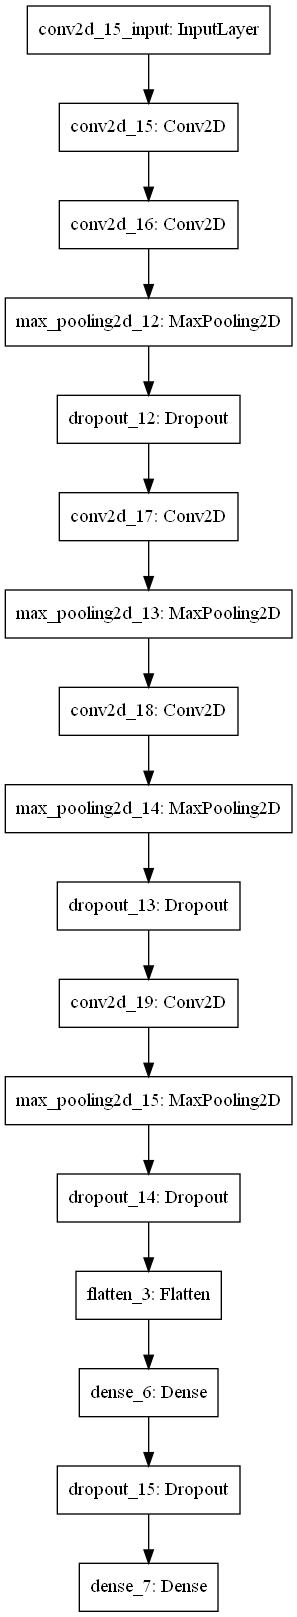

In [28]:
#illustrating the defined custom model
from tensorflow.keras.utils import plot_model
plot_model(emotion_model, to_file='sgd-model.png')

In [21]:
# list all data in history
print(emotion_model_info.history.keys())
# summarize history for accuracy
plt.plot(emotion_model_info.history['categorical_accuracy'])
plt.plot(emotion_model_info.history['val_categorical_accuracy'])
plt.title('SGD optimiser - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(emotion_model_info.history['loss'])
plt.plot(emotion_model_info.history['val_loss'])
plt.title('SGD optimiser - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'emotion_model_info' is not defined

-----------------------------------------------------------------------------------------------------------------------------------

In [17]:
%load_ext tensorboard
%tensorboard --logdir path+'/Tensorboard/'

Reusing TensorBoard on port 6006 (pid 17032), started 1:40:04 ago. (Use '!kill 17032' to kill it.)

-------------------------------------------------------------------------------------------------------------------------------------------------

**Convolution Matrix**

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
target_names = list(emotion_dict.values())
print(target_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [20]:
y_pred=emotion_model.predict(train_generator)
y_pred=np.argmax(y_pred,axis=1)
print('confusion matrix')
cm=confusion_matrix(train_generator.classes,y_pred)
print(cm)

confusion matrix
[[1211 1372 1263 2104 1390 1303 1368]
 [1232 1334 1246 2145 1375 1360 1318]
 [1259 1416 1219 2128 1364 1331 1294]
 [2056 2109 2060 3525 2207 2135 2172]
 [1270 1317 1291 2166 1317 1361 1315]
 [1263 1426 1285 2187 1359 1378 1335]
 [1284 1334 1293 2134 1337 1340 1289]]


In [21]:
y_pred=emotion_model.predict(validation_generator)
y_pred=np.argmax(y_pred,axis=1)
print('confusion matrix')
cm=confusion_matrix(validation_generator.classes,y_pred)
print(cm)

confusion matrix
[[123  25 109 255 145 184 117]
 [ 18   1  14  31  13  23  11]
 [142  33 109 265 167 185 123]
 [237  44 214 441 298 350 190]
 [163  30 140 292 214 222 172]
 [166  38 157 313 178 236 159]
 [126  19  84 213 129 145 115]]


C:\Users\logesh\AppData\Local\Temp/ipykernel_1412/2774912854.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_names)
C:\Users\logesh\AppData\Local\Temp/ipykernel_1412/2774912854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_names)


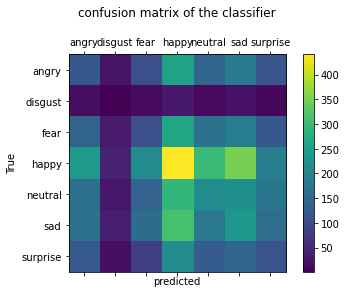

In [22]:
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(cm)
plt.title('confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + target_names)
ax.set_yticklabels([''] + target_names)
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()

In [23]:
Y_pred = emotion_model.predict(validation_generator, 400 // 4)

y_pred = np.argmax(Y_pred, axis=1)
print(validation_generator.classes)

print('Confusion Matrix')

cfm = confusion_matrix(validation_generator.classes, y_pred)

print(cfm)

[0 0 0 ... 6 6 6]
Confusion Matrix
[[139  31 114 223 145 182 124]
 [ 16   1  13  33  13  22  13]
 [129  32 111 248 178 201 125]
 [249  37 213 445 278 326 226]
 [168  29 148 324 185 227 152]
 [166  24 133 334 206 240 144]
 [108  36  95 203 139 147 103]]


In [24]:
print(classification_report(validation_generator.classes,y_pred))

              precision    recall  f1-score   support

           0       0.14      0.15      0.14       958
           1       0.01      0.01      0.01       111
           2       0.13      0.11      0.12      1024
           3       0.25      0.25      0.25      1774
           4       0.16      0.15      0.16      1233
           5       0.18      0.19      0.19      1247
           6       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



--------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
# %%javascript
# IPython.notebook.save_notebook()

In [26]:
# #pip install twilio
# from twilio.rest import Client

In [27]:
# import json
 
# # Opening JSON file
# f = open(path+'/twilo.json')
 
# # returns JSON object as
# # a dictionary
# data = json.load(f)
 
# # Iterating through the json
# # list
# print(data)
 
# # Closing file
# f.close()

In [28]:
# message =f"Accuracy : {emotion_model_info.history['categorical_accuracy'][-1]} Loss : {emotion_model_info.history['loss'][-1]} val_accuracy : {emotion_model_info.history['val_categorical_accuracy'][-1]} val_loss : {emotion_model_info.history['val_loss'][-1]}"

# # # Your Account Sid and Auth Token from twilio account

# # # instantiating the Client
# client = Client(data['account_sid'], data['auth_token'])
# # # sending message
# message = client.messages.create(body=message, from_= '+917305746782', to='+917305746782')
# # # printing the sid after success
# print(message.sid)

In [37]:
import os
len(os.listdir(path+'/dataset/FacialExpression-Dataset/Train/angry'))

10011

In [30]:
# #compress tensorboard data and check ponits
# checkpoints = shutil.make_archive('Checkpoints', "zip", path+'/Checkpoints/zip')
# tensorboard = shutil.make_archive('Tensorboard',"zip",path+'/Tensorboard/zip')

In [31]:
# from google.colab import files
# from shutil import  copy2

# t = input("C to copy to drive , D to download")
# if t == 'c' or t == 'C':
#   copy2('/content/Checkpoints.zip','/content/drive/MyDrive/7thSem_project/Checkpoints.zip')
#   copy2('/content/Tensorboard.zip','/content/drive/MyDrive/7thSem_project/Tensorboard.zip')
# elif t == 'd' or t =='D':

#   files.download('/content/Checkpoints.zip')

#   files.download('/content/Tensorboard.zip')

------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
import cv2
import numpy as np

In [30]:
# start the webcam feed
cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    bounding_box = cv2.CascadeClassifier('C:\\Users\\logesh\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Facial Expression', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

KeyboardInterrupt: 

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [35]:
stop_cuda()

In [1]:
# import seaborn
# import matplotlib.pyplot as plt
 
 
# def plot_confusion_matrix(data, labels, output_filename):
#     """Plot confusion matrix using heatmap.
 
#     Args:
#         data (list of list): List of lists with confusion matrix data.
#         labels (list): Labels which will be plotted across x and y axis.
#         output_filename (str): Path to output file.
 
#     """
#     seaborn.set(color_codes=True)
#     plt.figure(1, figsize=(16, 10))
 
#     plt.title("Confusion Matrix")
 
#     seaborn.set(font_scale=1.4)
#     ax = seaborn.heatmap(data, fmt='g', annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
#     ax.set_xticklabels(labels)
#     ax.set_yticklabels(labels)
 
#     ax.set(ylabel="True Label", xlabel="Predicted Label")
#     plt.show()
#     plt.savefig(output_filename, bbox_inches='tight', dpi=300)
#     plt.close()


# cm = [[139,  31, 114, 223, 145, 182, 124],
#  [ 16,   1,  13,  33,  13,  22,  13],
#  [129,  32, 111, 248, 178, 201, 125],
#  [249,  37, 213, 445, 278, 326, 226],
#  [168,  29, 148, 324, 185, 227, 152],
#  [166,  24, 133, 334, 206, 240, 144],
#  [108,  36,  95, 203, 139, 147, 103]]
# target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
 

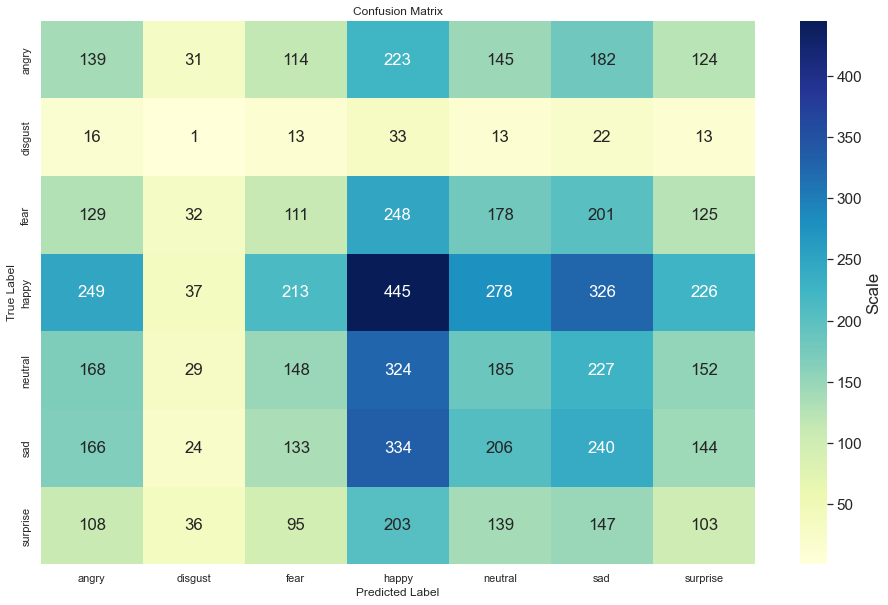

In [2]:
# plot_confusion_matrix(cm, target_names, "sgd_confusion_matrix.png")